# Simulations

Simulate some sparse data. Compare scVI, CVAE, and scanpy.

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [9]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [10]:
import os

import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import make_spd_matrix
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import torch
import imp

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference
from scvi.dataset import GeneExpressionDataset

In [11]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.models.cvae as cv

In [12]:
import scanpy.api as sc
from anndata import AnnData

### Function for generating data

In [255]:
D = 100
N = 1000
NUM_TRIAL = 100
base_exp = 2

In [256]:
def generate_data(diff):
    sigma_1 = make_spd_matrix(D)
    sigma_2 = make_spd_matrix(D)
    
    means_1 = np.array([base_exp for i in range(D)])
    means_2 = np.array([base_exp for i in range(D)])
    means_2[4] = base_exp + diff

    X_dense = np.concatenate([
        np.random.multivariate_normal(means_1, sigma_1, size=int(N/2)),
        np.random.multivariate_normal(means_2, sigma_2, size=int(N/2))])

    X = np.random.binomial(n=np.clip(np.round(X_dense).astype(np.int64), a_min=0, a_max=None),p=0.1)
    labels = np.array([0 for i in range(int(N/2))] + [1 for i in range(int(N/2))])
    
    dataset = GeneExpressionDataset(*GeneExpressionDataset.get_attributes_from_matrix(X, labels=labels))
    dataset.gene_names = np.array(list(range(D)))
    
    return X_dense, dataset

In [257]:
X_dense, gene_dataset = generate_data(10)
(gene_dataset.X == 0).sum()/(D*N)

0.81122

### Simulation

In [258]:
imp.reload(cv)
imp.reload(svi)
imp.reload(mn)

<module 'scvi_extensions.hypothesis_testing.mean' from '/Users/mincheolkim/Github/scVI-extensions/scvi_extensions/hypothesis_testing/mean.py'>

In [259]:
n_epochs=100
lr=1e-3
use_batches=False
use_cuda=False

In [260]:
supervised_bf = []
bf = []

for diff in [2]:

    X_dense, gene_dataset = generate_data(diff)
    
    # Fit scVI
    vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches, n_hidden=50, n_latent=10)
    infer = VariationalInference(
        vae, 
        gene_dataset, 
        train_size=0.9, 
        use_cuda=use_cuda,
        verbose=False,
        frequency=1)
    infer.train(n_epochs=n_epochs, lr=lr)
    
    # Fit CVAE
    cvae = cv.CVAE(gene_dataset.nb_genes, n_labels=gene_dataset.n_labels, n_batch=gene_dataset.n_batches * use_batches, n_hidden=50, n_latent=10)
    supervised_infer = svi.SupervisedVariationalInference(
        cvae, 
        gene_dataset, 
        train_size=0.9, 
        use_cuda=use_cuda,
        verbose=False,
        frequency=1)
    supervised_infer.train(n_epochs=n_epochs, lr=lr)
    
    supervised_null, supervised_de = mn.differential_expression(cvae, gene_dataset, [0,1], 100, testing=False)
    null, de = mn.differential_expression(vae, gene_dataset, [0,1], 100, testing=False)
    
    supervised_bf.append(supervised_de[0][1].query('gene == 4')['bayes_factor_mag'].values[0])
    bf.append(de[0][1].query('gene == 4')['bayes_factor_mag'].values[0])

training: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]
Sampling for differential expression...
Done sampling for differential expression...
Sampling for differential expression...
Done sampling for differential expression...


In [261]:
bf

[0.0960738281651885]

In [262]:
supervised_bf

[0.751015799078385]

In [263]:
de[0][1].head(5)

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
75,75,75,0.6131,0.460362,0.460362,0.000000e+00,1.0
2,2,2,0.5806,0.325237,0.325237,0.000000e+00,1.0
37,37,37,0.4299,-0.282259,0.282259,1.013312e-34,-1.0
45,45,45,0.5654,0.263107,0.263107,0.000000e+00,1.0
48,48,48,0.4373,-0.252127,0.252127,3.825717e-28,-1.0


In [264]:
supervised_de[0][1].head(5)

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
62,62,62,0.6937,0.817475,0.817475,0.000000e+00,1.0
4,4,4,0.3206,-0.751016,0.751016,1.104228e-262,-1.0
58,58,58,0.6675,0.696900,0.696900,0.000000e+00,1.0
77,77,77,0.6652,0.686554,0.686554,0.000000e+00,1.0
15,15,15,0.6560,0.645519,0.645519,0.000000e+00,1.0


In [265]:
adata = AnnData(gene_dataset.X)

In [266]:
adata.obs['group'] = gene_dataset.labels.reshape(-1)
adata.obs['group'] = adata.obs['group'].astype('category')

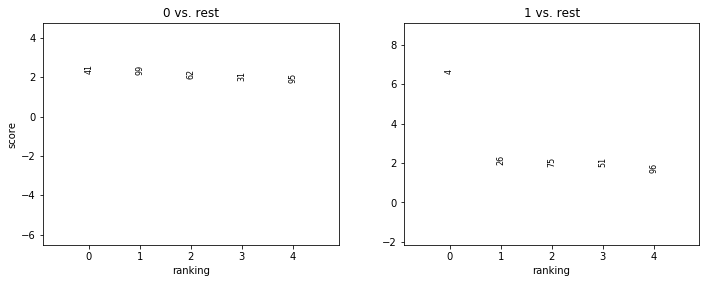

In [267]:
sc.tl.rank_genes_groups(adata, 'group')
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)